# Load the Data

In [5]:
import pandas as pd
import os 

data_dir = "/Users/arianabeloiu/Downloads/data_for_research/input"
file_names = [
    "Akmal_et_al_Malaysia_data.csv",
    "Guam_corals.csv",
    "NCRMP_Florida_corals.csv",
    "NCRMP_Puerto_Rico_corals.csv",
    "NCRMP_USVI_corals.csv",
    "Per_genus_persian_gulf_Hazraty-Kari_et_al.csv",
    "Persian_gulf_Hazraty-Kari_et_al.csv",
    "Sere_et_al_2015_Isle_de_la_Reunion_Disease_Data.csv"
] 

datasets = {file: pd.read_csv(os.path.join(data_dir, file)) for file in file_names}

# Preprocess the Data
Combine data if needed, ensuring each dataset has a column for disease prevalence and Endozoicomonas abundance. Handle missing values. Normalize/standardize columns for consistent scaling

In [7]:
import numpy as np  

for name, df in datasets.items():
    df["Source"] = name

all_data = pd.concat(datasets.values(), ignore_index=True) 

all_data = all_data.dropna(subset=["disease_prevalence", "Endozoicomonas_tissue"])

In [9]:
all_data["disease_prevalence"] = pd.to_numeric(all_data["disease_prevalence"], errors="coerce")
all_data["Endozoicomonas_tissue"] = pd.to_numeric(all_data["Endozoicomonas_tissue"], errors="coerce")  

all_data = all_data.dropna(subset=["disease_prevalence", "Endozoicomonas_tissue"])

# Carry out Bray-Curtis Dissimilarity Analysis 
Create a distance matrix as well as making sure the matrix is symmetric, and the diagonal (self-comparisons) must contain zeros, as well as all the values being numerical

In [11]:
import numpy as np
from scipy.spatial.distance import pdist, squareform

numeric_columns = ["disease_prevalence", "Endozoicomonas_tissue"]
data_matrix = all_data[numeric_columns].values

distance_matrix = pdist(data_matrix, metric="braycurtis")
square_matrix = squareform(distance_matrix)
square_matrix[np.isnan(square_matrix)] = 0

if not np.allclose(square_matrix, square_matrix.T):
    print("Matrix is not symmetric. Making it symmetric.")
    square_matrix = (square_matrix + square_matrix.T) / 2

# Ensure diagonal is hollow
np.fill_diagonal(square_matrix, 0)

# Create a PCoA Plot 
Now that the matrix is symmetric and clean, pass through a PCOA calculation function.

/Users/arianabeloiu/anaconda3/lib/python3.11/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:146: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.10978928407996875 and the largest is 7.287920522396075.
  warn(


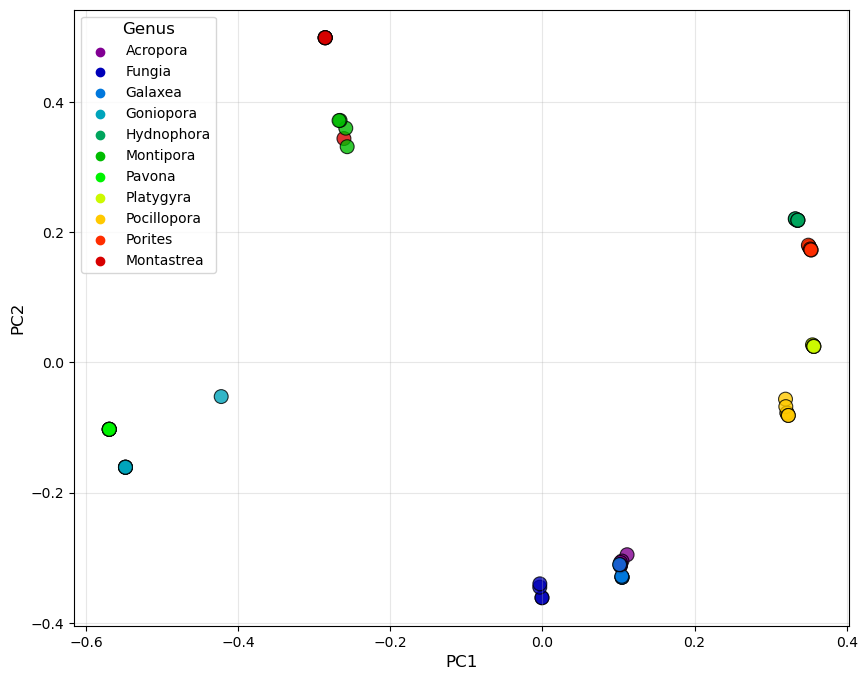

In [23]:
from skbio.stats.distance import DistanceMatrix
from skbio.stats.ordination import pcoa

#convert to distance matrix 
dm = DistanceMatrix(square_matrix)

#run PCOA calculations 
pcoa_results = pcoa(dm)

# Plot the results
import matplotlib.pyplot as plt
import seaborn as sns

if "Genus" not in all_data.columns:
    raise ValueError("The dataset does not contain a 'Genus' column.")

# Merge PCoA results with the genus information
pcoa_samples = pcoa_results.samples
pcoa_samples['Genus'] = all_data["Genus"].values  # Map the genus to the PCoA results

# Plot the PCoA with genus color-coding
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=pcoa_samples['PC1'],
    y=pcoa_samples['PC2'],
    hue=pcoa_samples['Genus'],
    palette='nipy_spectral',  # You can use other palettes like 'viridis', 'coolwarm', etc.
    s=100,  # Marker size
    edgecolor='k',  # Black edge around points
    alpha=0.8  # Transparency
)

plt.xlabel("PC1", fontsize=12)
plt.ylabel("PC2", fontsize=12)
plt.legend(title="Genus", fontsize=10, title_fontsize=12)
plt.grid(alpha=0.3)
plt.show()